In [3]:
import torchvision.models as models
from flashtorch.utils import load_image ,apply_transforms
from flashtorch.saliency import Backprop
import matplotlib as plt 
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
import pandas as pd
import sys
import cv2
import matplotlib.pyplot as plt
import torchvision.models as models

from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

In [4]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print('Device used:', device)

Device used: cpu


In [5]:
def load_data(img_path, label_path):
    train_image = sorted(glob.glob(os.path.join(img_path, '*.jpg')))
    train_label = pd.read_csv(label_path)
    train_label = train_label.iloc[:,1].values.tolist()
    
    train_data = list(zip(train_image, train_label))
    random.shuffle(train_data)
    
    train_set = train_data[:28800]
    valid_set = train_data[28800:]
    
    return train_set, valid_set

In [6]:
class hw3_dataset(Dataset):
    
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transform(img)
        label = self.data[idx][1]
        return img, label

In [7]:
train_set, valid_set = load_data('./train_img/', 'train.csv')



transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset = hw3_dataset(train_set,transform)
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

valid_dataset = hw3_dataset(valid_set,transform)
print(len(valid_dataset))
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)


NameError: name 'random' is not defined

In [49]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.Dropout2d(0.4),
            nn.LeakyReLU(negative_slope=0.05),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),     
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(negative_slope=0.05),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),            
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,padding=1),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(negative_slope=0.05),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3,padding=1),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(negative_slope=0.05),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            
        )
        self.fc = nn.Sequential(
            nn.Linear(3*3*128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        #image size (48,48)
        print("init",x.shape)
        x = self.conv1(x) #(24,24)
        print("1:",x.shape)
        x = self.conv2(x) #(12,12)
        print("2:",x.shape)
        x = self.conv3(x) #(6,6)
        print("3:",x.shape)
        x = self.conv4(x) #(3,3)
        print("4:",x.shape)
        x = x.view(-1, 3*3*128)
        x = self.fc(x)
        return x

In [54]:
image = load_image('./train_img/00001.jpg')

print(image)

input_ = apply_transforms(image,size = 48)
print(input_.shape)

<PIL.Image.Image image mode=RGB size=48x48 at 0x136461908>
torch.Size([1, 3, 224, 224])


In [51]:
model = Net()
model.load_state_dict(torch.load('./model_3channel/model_601.pth',map_location ='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [52]:
backprop = Backprop(model)

In [53]:
target_class = 7
backprop.visualize(input_ , target_class, guided = True)

init torch.Size([1, 3, 224, 224])
1: torch.Size([1, 32, 112, 112])
2: torch.Size([1, 64, 56, 56])
3: torch.Size([1, 128, 28, 28])
4: torch.Size([1, 128, 14, 14])


RuntimeError: shape '[-1, 1152]' is invalid for input of size 25088

In [39]:
from flashtorch.activmax import GradientAscent

In [40]:
model = models.vgg16(pretrained = True)

In [41]:
g_ascent = GradientAscent(model.features)

In [42]:
conv5_1 = model.features[24]
conv5_1_filters = [45, 271 ,363, 409]

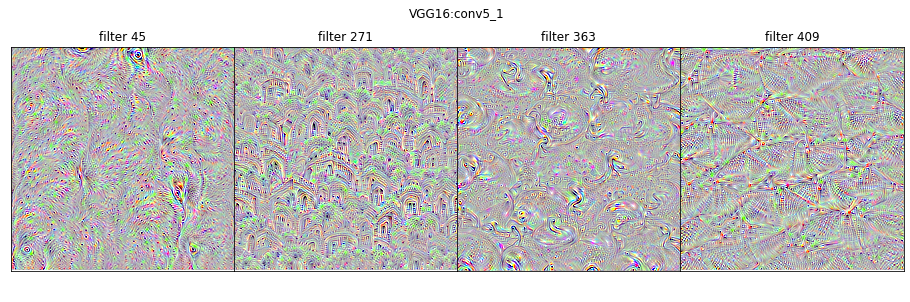

In [43]:
g_ascent.visualize(conv5_1 ,conv5_1_filters,title ='VGG16:conv5_1');